In [263]:
import os
import pickle
import pandas as pd

dir = '/home/wbjeong/cancer/PORPOISE/results_new/5foldcv/SNN_nll_surv_a0.0_omicreg1e-05_5foldcv_gc32/tcga_old_gbmlgg_SNN_nll_surv_a0.0_omicreg1e-05_5foldcv_gc32_s1'
# dir = '/home/wbjeong/cancer/PORPOISE/results_new/5foldcv/SNN_nll_surv_a0.0_omicreg1e-05_5foldcv_gc32/tcga_luad_SNN_nll_surv_a0.0_omicreg1e-05_5foldcv_gc32_s1'
# dir = '/home/wbjeong/cancer/PORPOISE/results_new/5foldcv/PorpoiseAMIL_nll_surv_a0.0_5foldcv_gc32/tcga_luad_PorpoiseAMIL_nll_surv_a0.0_5foldcv_gc32_s1'
out_dir = '/home/wbjeong/cancer/PORPOISE/results_new/'

# 주어진 디렉토리에서 모든 .pkl 파일 찾기
files = [f for f in os.listdir(dir) if f.endswith('.pkl')]
print(files)

# 모든 .pkl 파일을 하나의 데이터프레임으로 병합
file_paths = [os.path.join(dir, file) for file in files]

dicts = []
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        tmp = pickle.load(f)
        dicts.append(tmp)

df = pd.concat([pd.DataFrame.from_dict(x).T for x in dicts])

# 데이터프레임을 tcga_blca_train_merged_df.pkl 파일로 out_dir에 저장
with open(os.path.join(out_dir, 'tcga_luad_train_merged_df.pkl'), 'wb') as f:
    pickle.dump(df, f)

['split_latest_val_0_results.pkl', 'split_latest_val_1_results.pkl', 'split_latest_val_2_results.pkl', 'split_latest_val_3_results.pkl', 'split_latest_val_4_results.pkl']


In [718]:
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import pickle

def survival_analysis(target_cancer: str):
    with open(f"{target_cancer}_train_merged_df.pkl", 'rb') as f:
        train_df = pickle.load(f)

    train_df["status"] = [not bool(x) for x in train_df.censorship]
    train_df.survival = train_df.survival / 12
    train_df.risk = [x[0] for x in train_df.risk]
    train_df = train_df.sort_values(by="risk", ascending=False)

    train_high = train_df.head(int(train_df.shape[0] / 2))
    train_low = train_df.tail(int(train_df.shape[0] / 2))

    kmf = KaplanMeierFitter()
    kmf.fit(train_low.survival, train_low.status, label="low risk")
    ax_kmf = kmf.plot(color="blue", ci_show=False, show_censors=True)

    kmf.fit(train_high.survival, train_high.status, label="high risk")
    ax_kmf = kmf.plot(ax=ax_kmf, color="red", ci_show=False, show_censors=True)

    pval = logrank_test(train_low.survival, train_high.survival, train_low.status, train_high.status).p_value

    ax_kmf.set_title(f"P-value : {pval:.2e}")
    ax_kmf.set_xlabel("Years")
    ax_kmf.set_ylabel("Proportion Surviving")
    ax_kmf.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    ax_kmf.spines['top'].set_visible(False)
    ax_kmf.spines['right'].set_visible(False)
    ax_kmf.spines['bottom'].set_color('black')
    ax_kmf.spines['left'].set_color('black')
    ax_kmf.spines['bottom'].set_linewidth(1)
    ax_kmf.spines['left'].set_linewidth(1)

    return ax_kmf

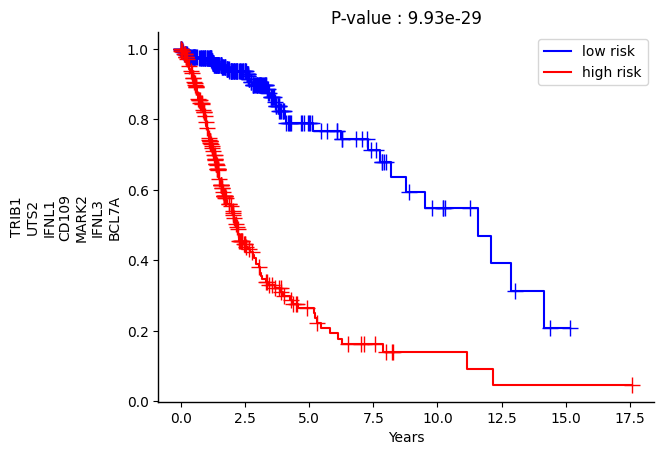

In [719]:
os.chdir(out_dir)
cancer_list = ['tcga_luad']

### survival_analysis 함수를 이용하여 각각의 데이터에 대한 Kaplan-Meier plot 그려서 저장하지 말고 출력하기

for cancer in cancer_list:
    ax_kmf = survival_analysis(cancer)

In [706]:
# Given validation c-index values
val_cindex_values = [
    0.8493384549722578,
    0.7792714657415438,
    0.7697707065980346,
    0.825382932166302,
    0.7932780847145487
]

# Calculate mean
mean_val_cindex = sum(val_cindex_values) / len(val_cindex_values)

# Calculate standard deviation
std_val_cindex = (sum([(x - mean_val_cindex) ** 2 for x in val_cindex_values]) / len(val_cindex_values)) ** 0.5

print(f"Mean validation c-index: {mean_val_cindex:.4f}")
print(f"Standard deviation of validation c-index: {std_val_cindex:.4f}")

Mean validation c-index: 0.8034
Standard deviation of validation c-index: 0.0297
